# QDM-QPLAD EDA

This notebook is for exploring the Quantile Delta Mapping - Quantile Preserving Analog Downscaling method. This method of statistical downscaling, introduced in [Gergel et al. 2023](https://doi.org/10.5194/gmd-17-191-2024), is of interest to collaborators, and this notebook will attempt to implement this method as a proof of concept for our CMIP6 statistical downscaling goals.  

The code used to do it is in a fork of the `xclim` package developed by the team who created this method: [https://github.com/ClimateImpactLab/xclim](https://github.com/ClimateImpactLab/xclim). 

The [ClimateImpactLab/dodola](https://github.com/ClimateImpactLab/dodola) repo contains the python code used to actually perform the downscaling. 

### Environment

This is an experimental notebook, and will use their forked version of `xclim`. The spec for the environment used to run this notebook on a Chinook compute node can be found in the `cil_xclim_env.yml` file, and you can create the environment by running `conda env create -f cil_xclim_env.yml`. 

If you are unable to load the `xclim` functionality specific to the CIL-forked version, it's possible that `pip` installed from PyPI - I'm not sure how to set a github repo in the env spec file. Just install using `pip` like so:

```
pip install git+https://github.com/ClimateImpactLab/xclim@master
```

### ERA5 daily data

We will also need ERA5 data at the daily resolution. Since the WRF simulations are done at an hourly frequency, we will need to resample that hourly data to the daily scale. Use the `resample_era5.py` and the `run_resample_era5.slurm` scripts in this folder to achieve this. 

### Regridding ERA5

We need that ERA5 data regridded in a couple of different ways. See the `regridding.ipynb` notebook in this folder to do that

## QDM adjustment

Now we will try first adjusting some GCM data.

From the paper:

> GCM projections for each variable, GCM, experiment, pixel, year, and day at a 1◦ × 1◦ resolution are bias-adjusted using the xclim Python package QDM implementation (Logan et al., 2021). To do this, QDM models for each pixel and day of the year are trained on a rolling 31 d centered window (±15 d) of daily ERA5 and GCM historical data from 1995 to 2014. For ERA5 reference data, we include the last 15 d from 1994 and the first 15 d from 2015, such that each day group contains 620 values (20 years × 31 d). For CMIP6 historical data, since the simulation ends in 2014, we do not include the additional 15 d from 2015 or 1994 for consistency. Each trained QDM model (per pixel and day of year) has 100 equally spaced quantiles in our implementation. We used an additive adjustment for maximum and minimum temperature and a multiplicative adjustment for precipitation. Each variable was bias-adjusted separately.

So, we will first need to load and regrid daily ERA5 data to the common grid. We will use the daily data created with the scripts referenced in the beginning of this notebook. 

In [1]:
from pathlib import Path
import dask
import xclim
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from xclim import sdba, set_options
from xclim.sdba.utils import equally_spaced_nodes
import xclim.indicators as xci
from dask.distributed import LocalCluster, Client

# downscaling project directory for writing inputs/outputs
downscaling_dir = Path("/beegfs/CMIP6/kmredilla/downscaling")

dask.config.set({"temporary-directory": "/beegfs/CMIP6/kmredilla/tmp"})

Spin up a dask cluster:

In [2]:
# The threads_per_worker=1 seems to have really helped with open_mfdataset()
# I think using a low number of workers is helping because very memory-intensive
#  operations are being done in parallel (like quantile operations with hundreds of qwuantiles)
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 251.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45617,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 251.56 GiB
Comm: tcp://127.0.0.1:39259,Total threads: 1
Dashboard: http://127.0.0.1:39721/status,Memory: 62.89 GiB
Nanny: tcp://127.0.0.1:42775,


Load up the common grid ERA5 dataset, this will be our reference dataset for QDM:

In [3]:
ref_ds = xr.open_mfdataset(downscaling_dir.joinpath("era5_common.nc"))
# use consistent names with the CMIP6 data
ref_ds = ref_ds.rename({"t2max": "tasmax"})
ref_da = ref_ds["tasmax"].chunk({"lat": 20, "lon": 20})
ref_da

<xarray.DataArray 'tasmax' (time: 7335, lat: 43, lon: 288)>
dask.array<rechunk-merge, shape=(7335, 43, 288), dtype=float32, chunksize=(7335, 20, 20), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1994-12-17 1994-12-18 ... 2015-01-15
  * lat          (lat) float64 90.0 89.06 88.12 87.17 ... 53.25 52.3 51.36 50.42
  * lon          (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
    spatial_ref  int64 ...
Attributes:
    regrid_method:  bilinear

Since much of this domain is NaN, we can subset down to the minimum bbox containing the ERA5 data:

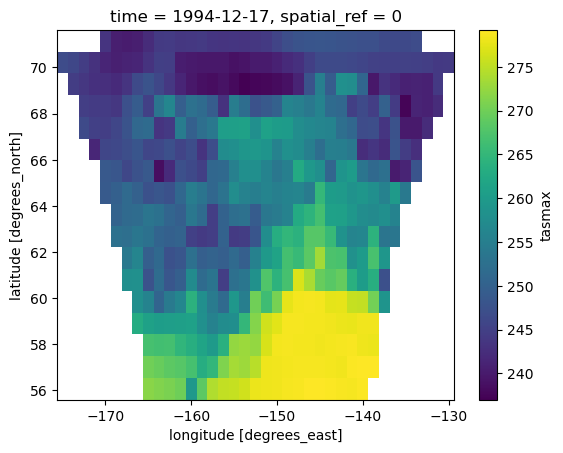

In [4]:
sel_di = dict(lon=slice(-176, -129), lat=slice(72, 55.5))
ref_da = ref_da.sel(sel_di)
ref_da.isel(time=0).plot()

Convert the calendar of ERA5 to noleap to match the CMIP6 calendars and convert from kelvin to celsius:

In [6]:
ref_da = ref_da.convert_calendar("noleap")
ref_da.attrs["units"] = "K"
ref_da = xclim.units.convert_units_to(ref_da, "degC")

Now we can load some CMIP6 data to be adjusted. We will load some historical tasmax data from the GFDL-ESM4 model for the same years:

In [5]:
hist_dir = Path(
    "/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid/GFDL-ESM4/historical/day/tasmax"
)
hist_fps = []
for year in range(1995, 2015):
    hist_fps.extend(sorted(hist_dir.glob(f"*{year}0101*.nc")))

hist_ds = xr.open_mfdataset(hist_fps).transpose("time", "lat", "lon")
hist_da = hist_ds["tasmax"].sel(sel_di).chunk({"time": -1, "lat": 20, "lon": 20})

Now we can run QDM training:

In [8]:
window_n = 31
quantiles_n = 100
kind = "+"
grouper = sdba.Grouper("time.dayofyear", window=int(window_n))

qdm = sdba.adjustment.QuantileDeltaMapping.train(
    ref=ref_da,
    hist=hist_da,
    kind=kind,
    group=grouper,
    nquantiles=equally_spaced_nodes(int(quantiles_n), eps=None),
)

And adjust:

In [9]:
year = 2000
halfyearwindow_n = 10

if isinstance(qdm, xr.Dataset):
    qdm = sdba.adjustment.QuantileDeltaMapping.from_dataset(qdm)

# Slice to get 15 days before and after our target year. This accounts
# for the rolling 31 day rolling window.
timeslice = slice(
    f"{year - halfyearwindow_n - 1}-12-17", f"{year + halfyearwindow_n + 1}-01-15"
)
simulation = hist_da.sel(
    time=timeslice
)  # TODO: Need a check to ensure we have all the data in this slice!

with set_options(sdba_extra_output=True):
    hist_adj = qdm.adjust(simulation, interp="nearest").sel(time=str(year))
    # make quantiles a coordinate of bias corrected output variable
    hist_adj = hist_adj["scen"].assign_coords(sim_q=hist_adj.sim_q)

hist_adj = hist_adj.to_dataset(name="tasmax").transpose("time", "lat", "lon")
hist_adj.load()

<xarray.Dataset>
Dimensions:      (lat: 17, lon: 37, time: 365)
Coordinates:
  * lat          (lat) float64 71.15 70.21 69.27 68.32 ... 57.96 57.02 56.07
  * lon          (lon) float64 -175.0 -173.8 -172.5 ... -132.5 -131.2 -130.0
  * time         (time) object 2000-01-01 12:00:00 ... 2000-12-31 12:00:00
    spatial_ref  int64 0
    height       float64 2.0
    sim_q        (time, lat, lon) float64 0.4118 0.4118 0.4118 ... 0.9375 0.9375
Data variables:
    tasmax       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan

Save the adjusted output, as we will need to re-grid this to the target grid:

In [10]:
hist_adj_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted.nc"
)
# having issues overwriting file if it exists?
hist_adj_fp.unlink()
hist_adj.to_netcdf(hist_adj_fp)

Alright, well it looks like that worked. 

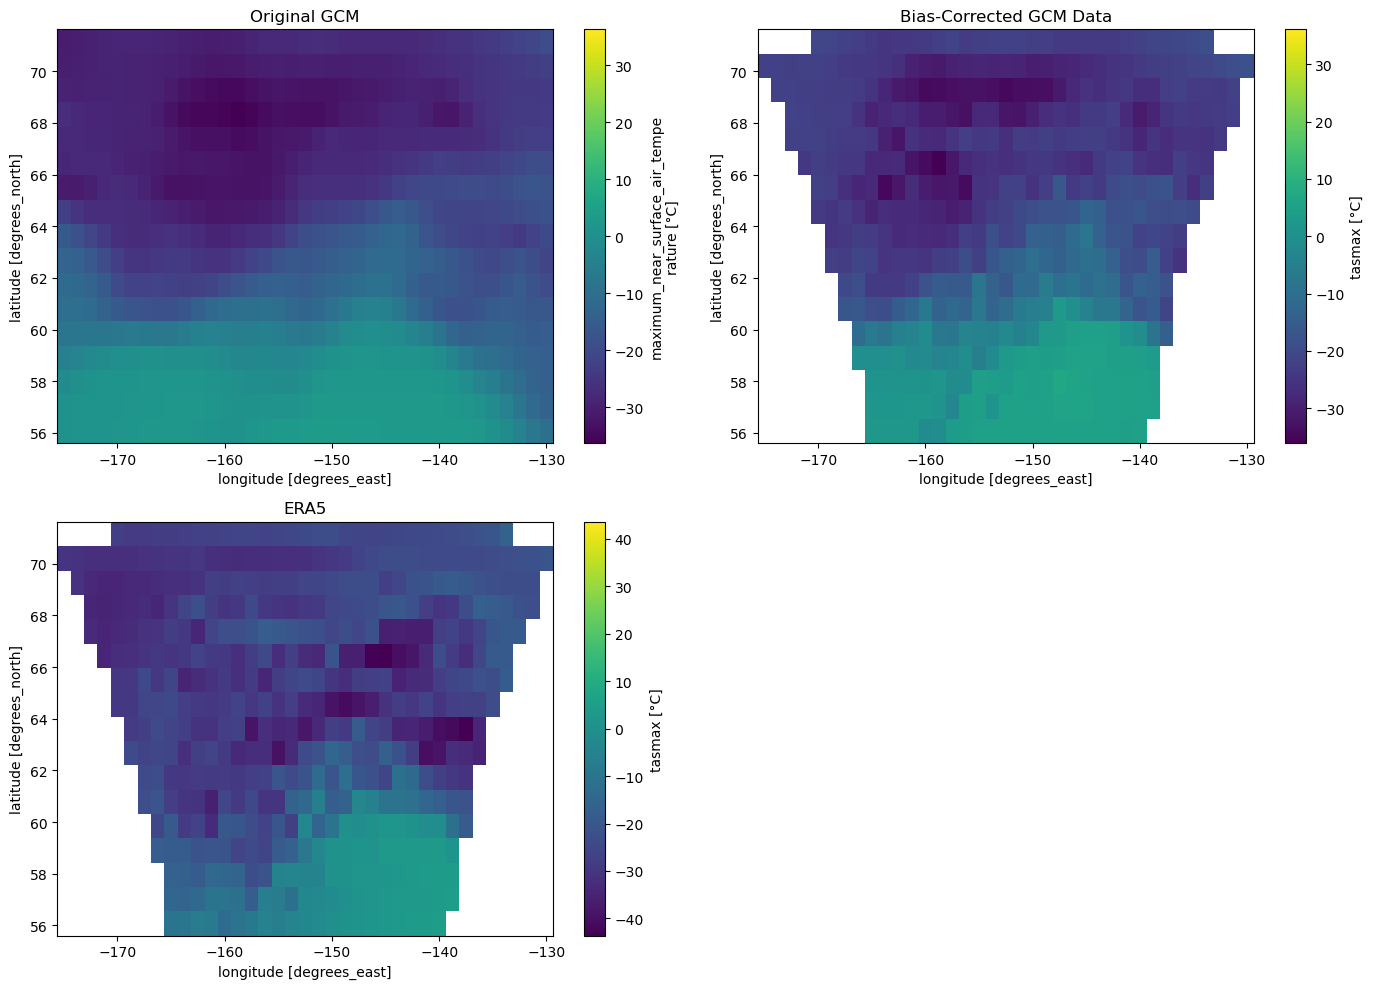

In [11]:
import matplotlib.pyplot as plt

# Select a time slice
time_index = 0  # Change this index to select a different time slice

# Plot the time slice from hist_da
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

hist_da.sel(time="2000-01-01").plot(ax=axes[0][0], cmap="viridis")
axes[0][0].set_title("Original GCM")

# Plot the time slice from hist_qdm
hist_adj["tasmax"].sel(time="2000-01-01").plot(ax=axes[0][1], cmap="viridis")
axes[0][1].set_title("Bias-Corrected GCM Data")

ref_da.sel(time="2000-01-01").plot(ax=axes[1][0], cmap="viridis")
axes[1][0].set_title("ERA5")

fig.delaxes(axes[1][1])

plt.tight_layout()
plt.show()

## QPLAD downscaling

Now let us try running the QPLAD downscaling. We will lean on the [dodola repo](https://github.com/ClimateImpactLab/dodola), which is the "Containerized application for running individual tasks in a larger, orchestrated CMIP6 bias-adjustment and downscaling workflow." There is some [code in there](https://github.com/ClimateImpactLab/dodola/blob/849215f575ba0c1a06164212fbd3a56e752ccacb/dodola/core.py) that makes use of the forked `xclim` package with classes like `QuantilePreservingAnalogDownscaling`.

First we should load up the coarse and fine reference datasets - the ERA5 data on the target grid, regridded in different ways - and make the same tweaks to prep it. 

ERA5-coarse:

In [5]:
# using open_mfdataset for dask
coarse_ref_ds = xr.open_mfdataset(downscaling_dir.joinpath("era5_coarse.nc")).rename(
    {"t2max": "tasmax"}
)

# use consistent names with the CMIP6 data
coarse_ref_da = coarse_ref_ds["tasmax"].chunk({"x": 10, "y": 10})
coarse_ref_da = coarse_ref_da.convert_calendar("noleap")
coarse_ref_da.attrs["units"] = "K"
coarse_ref_da = xclim.units.convert_units_to(coarse_ref_da, "degC")

coarse_ref_da

<xarray.DataArray 'tasmax' (time: 7330, y: 460, x: 443)>
dask.array<truediv, shape=(7330, 460, 443), dtype=float32, chunksize=(7330, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) object 1994-12-17 00:00:00 ... 2015-01-15 00:00:00
    spatial_ref  int64 0
  * x            (x) float64 -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y            (y) float64 2.476e+06 2.472e+06 ... 6.402e+05 6.362e+05
    lon          (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear
    units:          °C

ERA5-fine

In [3]:
fine_ref_da = xr.open_mfdataset(downscaling_dir.joinpath("era5_fine.nc")).rename(
    {"t2max": "tasmax"}
)
# fine_ref_da = xr.open_dataset(downscaling_dir.joinpath("era5_fine.nc")).rename(
#     {"t2max": "tasmax"}
# )
# use consistent names with the CMIP6 data
fine_ref_da = fine_ref_da["tasmax"].chunk({"x": 10, "y": 10})
fine_ref_da = fine_ref_da.convert_calendar("noleap")
fine_ref_da.attrs["units"] = "K"
fine_ref_da = xclim.units.convert_units_to(fine_ref_da, "degC")

fine_ref_da

<xarray.DataArray 'tasmax' (time: 7330, y: 460, x: 443)>
dask.array<truediv, shape=(7330, 460, 443), dtype=float32, chunksize=(7330, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -8.277e+05 -8.237e+05 ... 9.402e+05 9.442e+05
  * y        (y) float64 2.476e+06 2.472e+06 2.468e+06 ... 6.402e+05 6.362e+05
  * time     (time) object 1994-12-17 00:00:00 ... 2015-01-15 00:00:00
Attributes:
    coordinates:   lat lon
    grid_mapping:  spatial_ref
    units:         °C

Some slices from each of those datasets:

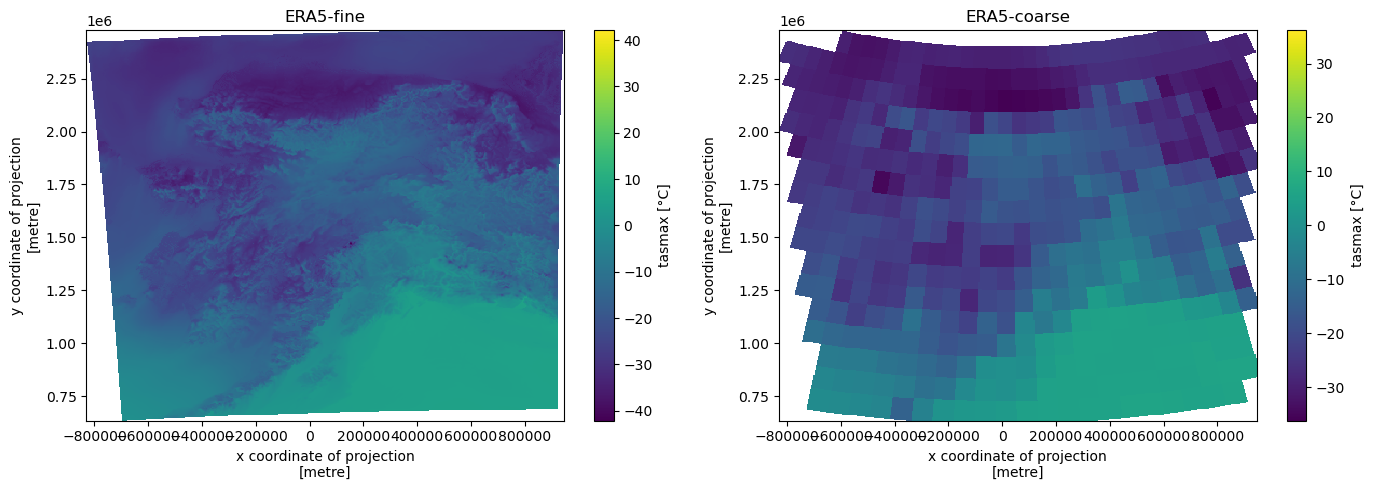

In [8]:
import matplotlib.pyplot as plt

# Select a time slice
time_index = 0  # Change this index to select a different time slice

# Plot the time slice from hist_da
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

fine_ref_da.isel(time=0).plot(ax=axes[0], cmap="viridis")
axes[0].set_title("ERA5-fine")

coarse_ref_da.isel(time=0).plot(ax=axes[1], cmap="viridis")
axes[1].set_title("ERA5-coarse")

plt.tight_layout()
plt.show()

Due to errors in the training step with the full extent, we will try with a bounding box that excludes all nodata from the edges, and is considerably smaller than the full domain to help with memory issues. 

Here is that extent, from ERA5-coarse:

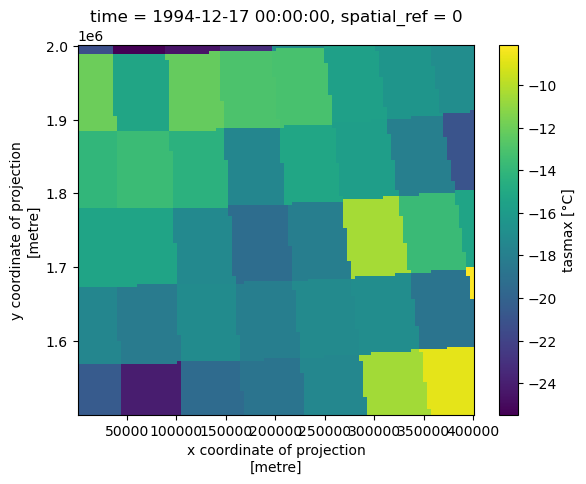

In [6]:
fine_nonan_sel_di = dict(x=slice(-6.5e5, 7e5), y=slice(2.35e6, 7.2e5))
# having troubles with downscaling on even that maximum valid extent, so let's try a smaller subset
fine_nonan_sel_di = dict(x=slice(0, 4e5), y=slice(2e6, 1.5e6))
coarse_ref_da.isel(time=0).sel(fine_nonan_sel_di).plot()

Perform the spatial subsets:

In [6]:
coarse_ref_da = coarse_ref_da.sel(fine_nonan_sel_di)
fine_ref_da = fine_ref_da.sel(fine_nonan_sel_di)

Now train the downscaling object. Again, this is based off the above `core` module of the `dodola` repo / package linked above:

In [7]:
# QPLAD method requires that the number of quantiles equals
# the number of days in each day group
# e.g. 20 years of data and a window of 31 = 620 quantiles
window_n = 31
kind = "+"
grouper = sdba.Grouper("time.dayofyear", window=int(window_n))

assert len(coarse_ref_da.time) == len(fine_ref_da.time)
quantiles_n = 620

# check number of years in input data (subtract 2 for the +/- 15 days on each end)
num_years = len(np.unique(fine_ref_da.time.dt.year)) - 2

assert (num_years * int(window_n)) == quantiles_n

qplad = sdba.adjustment.QuantilePreservingAnalogDownscaling.train(
    ref=coarse_ref_da,
    hist=fine_ref_da,
    kind=kind,
    group=grouper,
    nquantiles=quantiles_n,
)

In the spirit of trying to "[avoid very large graphs](https://docs.dask.org/en/stable/best-practices.html#avoid-very-large-graphs)", we will compute the trained dataset object before moving on to the adjustment step. Not sure if this helps for sure or not. 

In [8]:
qplad.ds.load()

<xarray.Dataset>
Dimensions:       (x: 100, y: 125, dayofyear: 365, quantiles: 620)
Coordinates:
  * x             (x) float64 2.121e+03 6.13e+03 1.014e+04 ... 3.95e+05 3.99e+05
  * y             (y) float64 1.999e+06 1.995e+06 ... 1.506e+06 1.502e+06
  * dayofyear     (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * quantiles     (quantiles) float64 0.0008065 0.002419 ... 0.9976 0.9992
    spatial_ref   int64 0
    lat           (y, x) float64 67.95 67.95 67.95 67.95 ... 63.28 63.28 63.27
    lon           (y, x) float64 -153.9 -153.9 -153.8 ... -146.2 -146.1 -146.0
Data variables:
    af            (x, y, dayofyear, quantiles) float32 2.92 0.5078 ... -2.689
    ref_coarse_q  (x, y, dayofyear, quantiles) float32 -37.54 -36.6 ... 3.11
Attributes:
    _xclim_adjustment:  {"py/object": "xclim.sdba.adjustment.QuantilePreservi...
    adj_params:         QuantilePreservingAnalogDownscaling(group=Grouper(add...

Now we will load a single year of bias-adjusted historical GCM data to downscale. We need the data that has been NN-resampled from the coarse common CMIP6 grid to the target grid following the QDM bias-adjustment. 

In [18]:
year = 2000
hist_adj_fine_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted_fine.nc"
)
hist_adj_fine = xr.open_dataset(hist_adj_fine_fp)
# subset to the same region as training
hist_adj_fine = hist_adj_fine.sel(fine_nonan_sel_di)
hist_adj_fine

<xarray.Dataset>
Dimensions:      (time: 365, y: 125, x: 100)
Coordinates:
  * time         (time) object 2000-01-01 12:00:00 ... 2000-12-31 12:00:00
    spatial_ref  int64 ...
    height       float64 ...
  * x            (x) float64 2.121e+03 6.13e+03 1.014e+04 ... 3.95e+05 3.99e+05
  * y            (y) float64 1.999e+06 1.995e+06 ... 1.506e+06 1.502e+06
    lon          (y, x) float64 ...
    lat          (y, x) float64 ...
Data variables:
    sim_q        (time, y, x) float32 ...
    tasmax       (time, y, x) float32 ...
Attributes:
    regrid_method:  nearest_s2d

Now we call the `adjust` method:

In [44]:
# .adjust method expects sim_q as a coordinate
hist_adj_qplad = qplad.adjust(hist_adj_fine.set_coords(["sim_q"])["tasmax"])

Here's a look at a single day time slice from the bias-adjusted GCM (left) and downscaled version (right):

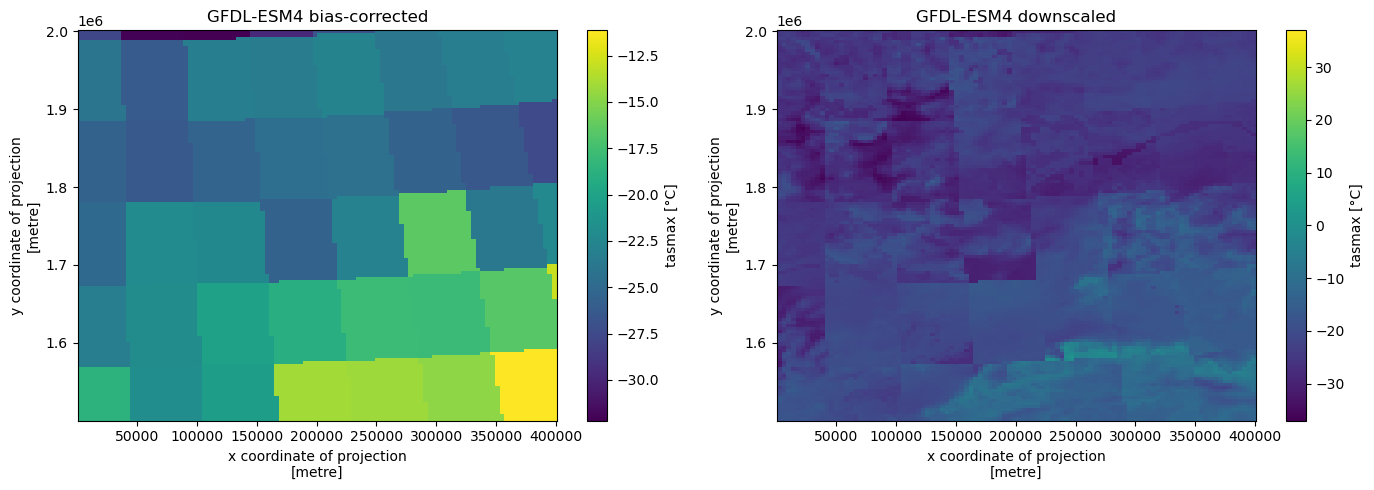

In [45]:
# Select a time slice
time_index = 0

# Plot the time slice from hist_da
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

hist_adj_fine["tasmax"].isel(time=0).plot(ax=axes[0], cmap="viridis")
axes[0].set_title("GFDL-ESM4 bias-corrected")

hist_adj_qplad.rename("tasmax").transpose("y", "x", "time").isel(time=0).plot(
    ax=axes[1], cmap="viridis"
)
axes[1].set_title("GFDL-ESM4 downscaled")

plt.tight_layout()
plt.show()

Here is a look at all pixels averaged over the year of data, to see if this helps with the weird artifacts of the resampled CMIP6 common grid that are evident in the above plot:

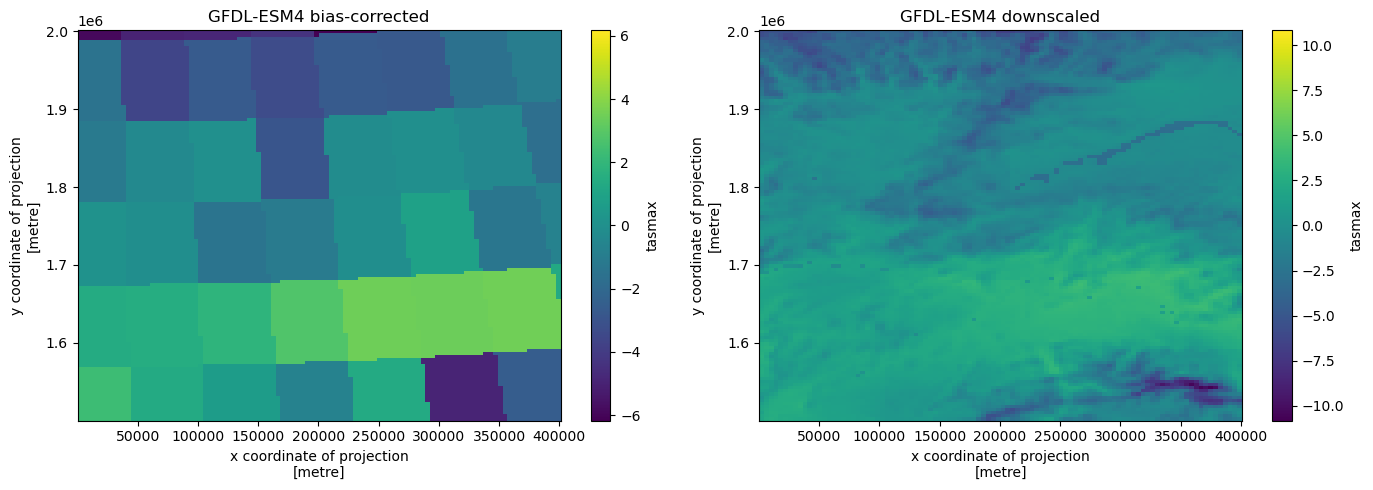

In [25]:
# Plot the time slice from hist_da
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

hist_adj_fine["tasmax"].mean(dim="time").plot(ax=axes[0], cmap="viridis")
axes[0].set_title("GFDL-ESM4 bias-corrected")

hist_adj_qplad.rename("tasmax").transpose("y", "x", "time").mean(dim="time").plot(
    ax=axes[1], cmap="viridis"
)
axes[1].set_title("GFDL-ESM4 downscaled")

plt.tight_layout()
plt.show()

And here is another example of summarizing over the year axis, this time using the maximum consecutive warm days indicator:

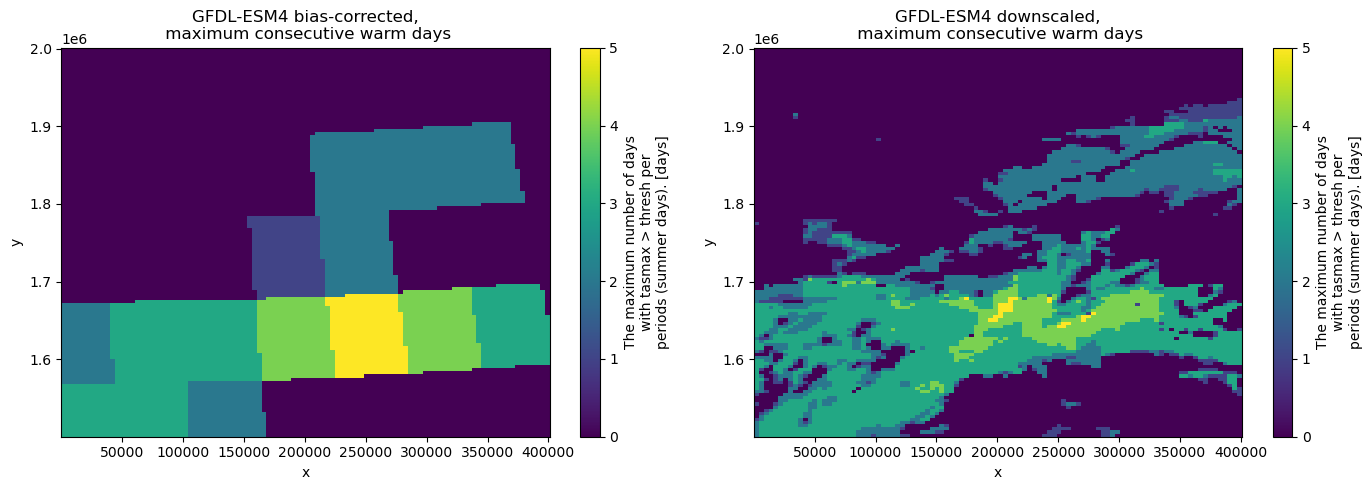

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# doing this to silence warnings about missing CF attributes
with xclim.set_options(
    cf_compliance="log",
):
    xci.atmos.maximum_consecutive_warm_days(hist_adj_fine["tasmax"]).plot(
        ax=axes[0], cmap="viridis"
    )
    xci.atmos.maximum_consecutive_warm_days(hist_adj_qplad.rename("tasmax")).transpose(
        "y", "x", "time"
    ).plot(ax=axes[1], cmap="viridis")

axes[0].set_title("GFDL-ESM4 bias-corrected,\n maximum consecutive warm days")
axes[1].set_title("GFDL-ESM4 downscaled,\n maximum consecutive warm days")

plt.tight_layout()
plt.show()

#### Downscaling unadjusted GCM

Unadjusted GCM that has been regridded to target grid via nearest neighbors:

In [39]:
year = 2000
hist_fine_fp = downscaling_dir.joinpath(f"GFDL-ESM4_historical_tasmax_{year}_fine.nc")
hist_fine_ds = xr.open_dataset(hist_fine_fp)
hist_fine_ds = hist_fine_ds.sel(fine_nonan_sel_di)
# qplad expects this but it is not present for non-adjusted data
# it would be the same though because sim_q is simply the quantile
# of each element of hist_fine_ds["tasmax"] within its group
hist_fine_ds["sim_q"] = hist_adj_fine.sim_q

hist_unadj_qplad = qplad.adjust(hist_fine_ds.set_coords(["sim_q"])["tasmax"])

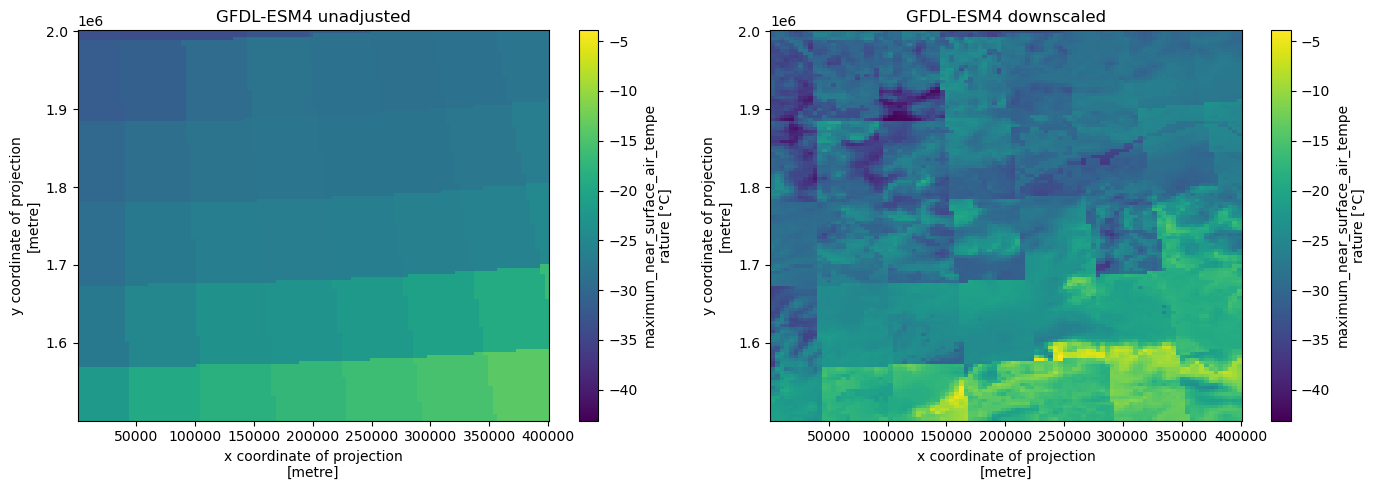

In [43]:
# Select a time slice
time_index = 0

# Determine the min and max values for the color scale
vmin = min(
    hist_fine_ds["tasmax"].isel(time=time_index).min().values,
    hist_unadj_qplad.isel(time=time_index).min().values,
)
vmax = max(
    hist_fine_ds["tasmax"].isel(time=time_index).max().values,
    hist_unadj_qplad.isel(time=time_index).max().values,
)

# Plot the time slice from hist_da
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

hist_fine_ds["tasmax"].isel(time=time_index).plot(
    ax=axes[0], cmap="viridis", vmin=vmin, vmax=vmax
)
axes[0].set_title("GFDL-ESM4 unadjusted")

hist_unadj_qplad.rename("tasmax").transpose("y", "x", "time").isel(
    time=time_index
).plot(ax=axes[1], cmap="viridis", vmin=vmin, vmax=vmax)
axes[1].set_title("GFDL-ESM4 downscaled")

plt.tight_layout()
plt.show()

Plot all four together

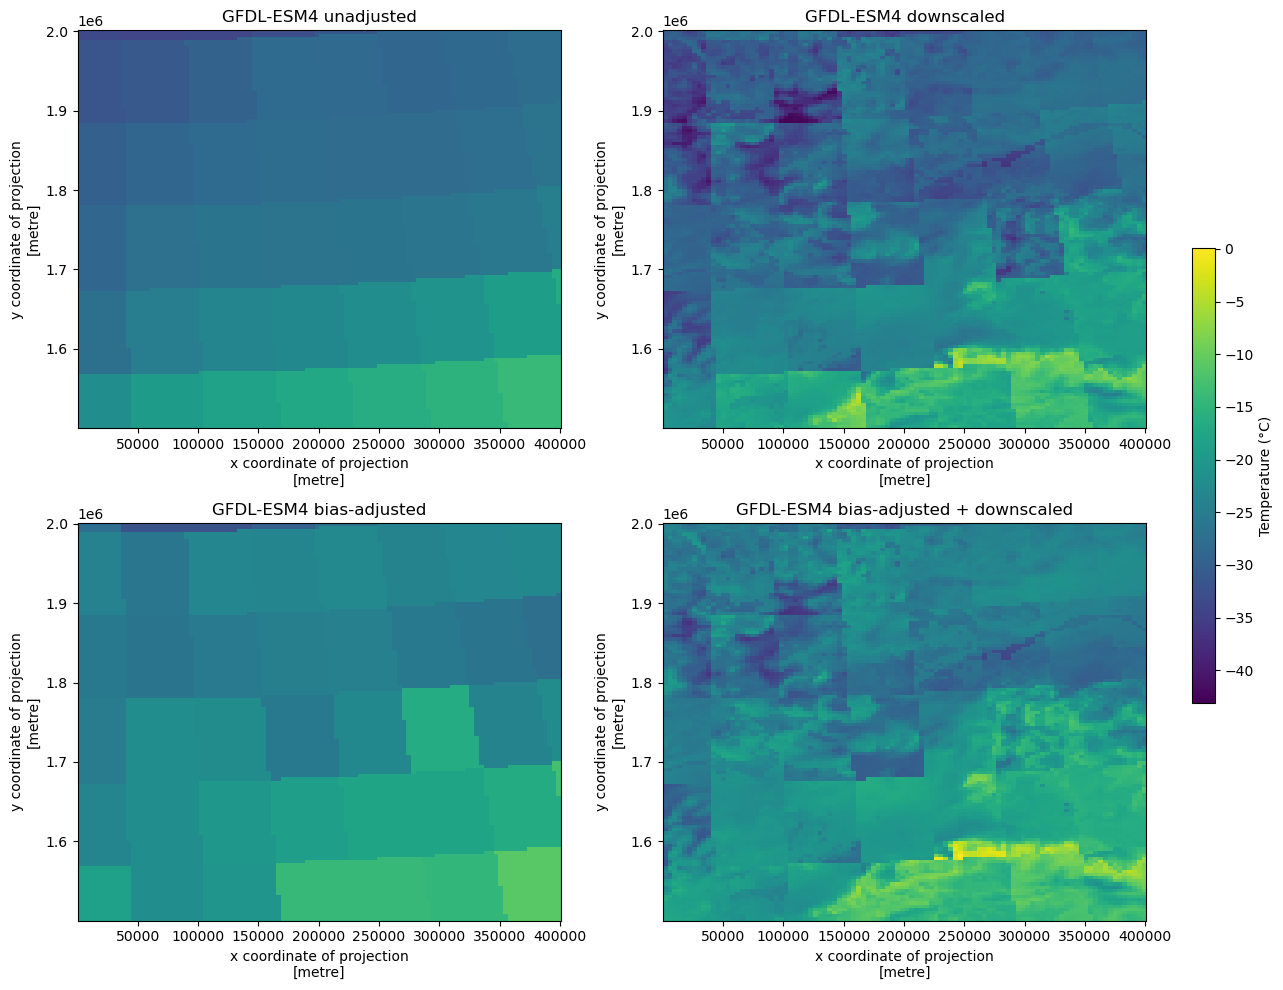

In [51]:
# Select a time slice
time_index = 0

# Determine the min and max values for the color scale from all of hist_fine_ds, hist_adj_fine, hist_adj_qplad, and hist_unadj_qplad
vmin = min(
    hist_fine_ds["tasmax"].isel(time=time_index).min().values,
    hist_adj_fine["tasmax"].isel(time=time_index).min().values,
    hist_adj_qplad.isel(time=time_index).min().values,
    hist_unadj_qplad.isel(time=time_index).min().values,
)
vmax = max(
    hist_fine_ds["tasmax"].isel(time=time_index).max().values,
    hist_adj_fine["tasmax"].isel(time=time_index).max().values,
    hist_adj_qplad.isel(time=time_index).max().values,
    hist_unadj_qplad.isel(time=time_index).max().values,
)

# plot all four together
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# unadjusted GFDL-ESM4
im0 = (
    hist_fine_ds["tasmax"]
    .isel(time=time_index)
    .plot(ax=axes[0][0], cmap="viridis", vmin=vmin, vmax=vmax, add_colorbar=False)
)
axes[0][0].set_title("GFDL-ESM4 unadjusted")

# downscaled unadjusted GFDL-ESM4
im1 = (
    hist_unadj_qplad.rename("tasmax")
    .transpose("y", "x", "time")
    .isel(time=time_index)
    .plot(ax=axes[0][1], cmap="viridis", vmin=vmin, vmax=vmax, add_colorbar=False)
)
axes[0][1].set_title("GFDL-ESM4 downscaled")

# bias-corrected GFDL-ESM4
im2 = (
    hist_adj_fine["tasmax"]
    .isel(time=time_index)
    .plot(ax=axes[1][0], cmap="viridis", vmin=vmin, vmax=vmax, add_colorbar=False)
)
axes[1][0].set_title("GFDL-ESM4 bias-adjusted")

# downscaled bias-corrected GFDL-ESM4
im3 = (
    hist_adj_qplad.rename("tasmax")
    .transpose("y", "x", "time")
    .isel(time=time_index)
    .plot(ax=axes[1][1], cmap="viridis", vmin=vmin, vmax=vmax, add_colorbar=False)
)
axes[1][1].set_title("GFDL-ESM4 bias-adjusted + downscaled")

# Adjust layout to make space for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])

# Add a single colorbar for all subplots
cbar = fig.colorbar(
    im0, ax=axes.ravel().tolist(), orientation="vertical", fraction=0.02, pad=0.04
)
cbar.set_label("Temperature (°C)")

plt.show()

Unadjusted GCM that has been regridded to target grid via bilinear:

In [10]:
year = 2000
# need ot make sure we have "adjusted" GCM data as this has the sim_q coordinate
hist_adj_fine_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted_fine.nc"
)
hist_adj_fine = xr.open_dataset(hist_adj_fine_fp)

hist_fine_fp = downscaling_dir.joinpath(
    "gfdl_historical_tasmax_fine_bilinear",
    f"gfdl_historical_tasmax_fine_bilinear_{year}.nc",
)
hist_fine_ds = xr.open_dataset(hist_fine_fp)
hist_fine_ds = hist_fine_ds.sel(fine_nonan_sel_di)
# qplad expects this but it is not present for non-adjusted data
# it would be the same though because sim_q is simply the quantile
# of each element of hist_fine_ds["tasmax"] within its group
hist_fine_ds["sim_q"] = hist_adj_fine.sim_q

hist_unadj_qplad = qplad.adjust(hist_fine_ds.set_coords(["sim_q"])["tasmax"])

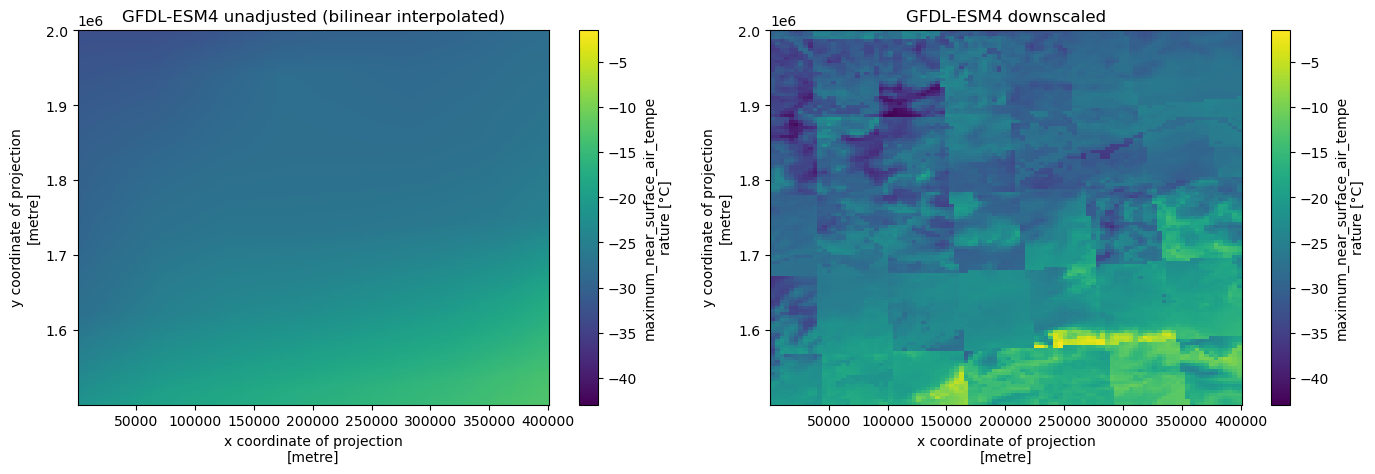

In [11]:
# Select a time slice
time_index = 0

# Determine the min and max values for the color scale
vmin = min(
    hist_fine_ds["tasmax"].isel(time=time_index).min().values,
    hist_unadj_qplad.isel(time=time_index).min().values,
)
vmax = max(
    hist_fine_ds["tasmax"].isel(time=time_index).max().values,
    hist_unadj_qplad.isel(time=time_index).max().values,
)

# Plot the time slice from hist_da
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

hist_fine_ds["tasmax"].isel(time=time_index).plot(
    ax=axes[0], cmap="viridis", vmin=vmin, vmax=vmax
)
axes[0].set_title("GFDL-ESM4 unadjusted (bilinear interpolated)")

hist_unadj_qplad.rename("tasmax").transpose("y", "x", "time").isel(
    time=time_index
).plot(ax=axes[1], cmap="viridis", vmin=vmin, vmax=vmax)
axes[1].set_title("GFDL-ESM4 downscaled")

plt.tight_layout()
plt.show()

QPLAD with ERA5 "Coarse" created using bilinear interpolation:

In [12]:
# load coarse reference data which has been smoothed with bilinear interpolation
coarse_ref_da = (
    xr.open_mfdataset(downscaling_dir.joinpath("era5_coarse_bilinear.nc"))
    .sel(fine_nonan_sel_di)
    .rename({"t2max": "tasmax"})["tasmax"]
    .chunk({"x": 10, "y": 10})
)
coarse_ref_da = coarse_ref_da.convert_calendar("noleap")

# fine reference data
fine_ref_da = (
    xr.open_mfdataset(downscaling_dir.joinpath("era5_fine.nc"))
    .rename({"t2max": "tasmax"})["tasmax"]
    .chunk({"x": 10, "y": 10})
)
fine_ref_da = fine_ref_da.convert_calendar("noleap")

fine_ref_da.attrs["units"] = "K"
fine_ref_da = xclim.units.convert_units_to(fine_ref_da, "degC")
coarse_ref_da.attrs["units"] = fine_ref_da.attrs["units"]

# subset for efficiency
fine_nonan_sel_di = dict(x=slice(0, 4e5), y=slice(2e6, 1.5e6))
coarse_ref_da = coarse_ref_da.sel(fine_nonan_sel_di)
fine_ref_da = fine_ref_da.sel(fine_nonan_sel_di)

# QPLAD stuff
window_n = 31
kind = "+"
grouper = sdba.Grouper("time.dayofyear", window=int(window_n))
assert len(coarse_ref_da.time) == len(fine_ref_da.time)
quantiles_n = 620
num_years = len(np.unique(fine_ref_da.time.dt.year)) - 2
assert (num_years * int(window_n)) == quantiles_n

qplad = sdba.adjustment.QuantilePreservingAnalogDownscaling.train(
    ref=coarse_ref_da,
    hist=fine_ref_da,
    kind=kind,
    group=grouper,
    nquantiles=quantiles_n,
)

In [15]:
qplad.ds.load()

<xarray.Dataset>
Dimensions:       (x: 100, y: 125, dayofyear: 365, quantiles: 620)
Coordinates:
  * x             (x) float64 2.121e+03 6.13e+03 1.014e+04 ... 3.95e+05 3.99e+05
  * y             (y) float64 1.999e+06 1.995e+06 ... 1.506e+06 1.502e+06
  * dayofyear     (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * quantiles     (quantiles) float64 0.0008065 0.002419 ... 0.9976 0.9992
    spatial_ref   int64 0
    lat           (y, x) float64 67.95 67.95 67.95 67.95 ... 63.28 63.28 63.27
    lon           (y, x) float64 -153.9 -153.9 -153.8 ... -146.2 -146.1 -146.0
Data variables:
    af            (x, y, dayofyear, quantiles) float32 -272.4 -272.4 ... -276.5
    ref_coarse_q  (x, y, dayofyear, quantiles) float32 237.8 239.3 ... 275.0
Attributes:
    _xclim_adjustment:  {"py/object": "xclim.sdba.adjustment.QuantilePreservi...
    adj_params:         QuantilePreservingAnalogDownscaling(group=Grouper(add...

In [16]:
year = 2000
hist_adj_fine_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted_fine.nc"
)
hist_adj_fine = xr.open_dataset(hist_adj_fine_fp)
# subset to the same region as training
hist_adj_fine = hist_adj_fine.sel(fine_nonan_sel_di)
hist_adj_qplad = qplad.adjust(
    hist_adj_fine.set_coords(["sim_q"])["tasmax"].chunk({"x": 20, "y": 20})
)

In [25]:
year = 2000
hist_fine_bl_fp = downscaling_dir.joinpath(
    "gfdl_historical_tasmax_fine_bilinear",
    f"gfdl_historical_tasmax_fine_bilinear_{year}.nc",
)
hist_fine_bl_ds = xr.open_mfdataset(hist_fine_bl_fp)
# subset to the same region as training
hist_fine_bl_ds = hist_fine_bl_ds.sel(fine_nonan_sel_di)
hist_fine_bl_ds["sim_q"] = hist_adj_fine.sim_q
hist_fine_bl = hist_fine_bl_ds.set_coords(["sim_q"])["tasmax"].chunk({"x": 20, "y": 20})

hist_bl_qplad = qplad.adjust(hist_fine_bl)

/home/kmredilla/miniconda3/envs/cil-xclim/lib/python3.9/site-packages/distributed/worker.py:2991: UserWarning: Large object of size 345.31 MiB detected in task graph: 
  ([('x', 'y', 'dayofyear', 'quantiles'), <xarray.Va ... nt Factors'}],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


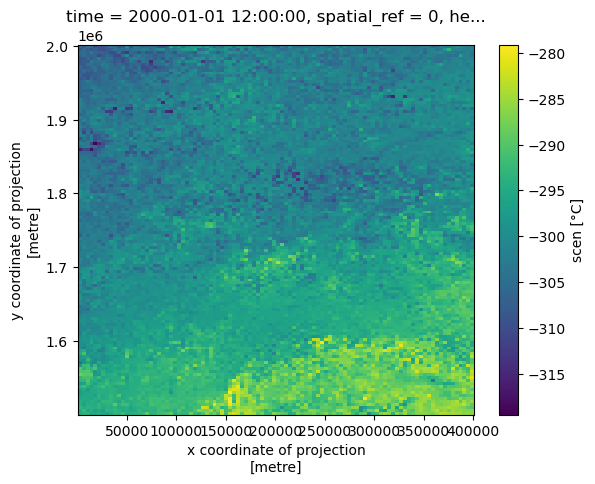

In [27]:
hist_bl_qplad.load()

#### nested coarse-target grid

Given the weirdness going on in the above example, I figured it was worth an attempt where the downscaling is done from a grid to a nested grid. We have separately regridded the ERA5 data to a WGS84 grid that is nested in the coarse GCM grid. We will try to implement the above methods using that.

First we should load up the coarse and fine reference datasets - the ERA5 data on the target grid, regridded in different ways - and make the same tweaks to prep it. 

ERA5-coarse:

In [3]:
# using open_mfdataset for dask
coarse_ref_ds = xr.open_mfdataset(
    downscaling_dir.joinpath("era5_coarse_wgs84.nc")
).rename({"t2max": "tasmax"})

# use consistent names with the CMIP6 data
coarse_ref_da = coarse_ref_ds["tasmax"].chunk({"lon": 10, "lat": 10})
coarse_ref_da = coarse_ref_da.convert_calendar("noleap")
coarse_ref_da.attrs["units"] = "K"
coarse_ref_da = xclim.units.convert_units_to(coarse_ref_da, "degC")

coarse_ref_da

<xarray.DataArray 'tasmax' (time: 7330, lat: 400, lon: 555)>
dask.array<truediv, shape=(7330, 400, 555), dtype=float32, chunksize=(7330, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) object 1994-12-17 00:00:00 ... 2015-01-15 00:00:00
    spatial_ref  int64 0
  * lat          (lat) float64 57.02 57.05 57.09 57.12 ... 71.08 71.12 71.15
  * lon          (lon) float64 -175.0 -174.9 -174.8 ... -130.2 -130.1 -130.0
Attributes:
    regrid_method:  bilinear
    units:          °C

ERA5-fine

In [4]:
era5_fine_wgs84_dir = downscaling_dir.joinpath("era5_fine_wgs84")
fine_ref_fps = era5_fine_wgs84_dir.glob(f"*t2max*.nc")

fine_ref_da = xr.open_mfdataset(fine_ref_fps).rename({"t2max": "tasmax"})
# fine_ref_da = xr.open_dataset(downscaling_dir.joinpath("era5_fine.nc")).rename(
#     {"t2max": "tasmax"}
# )
# use consistent names with the CMIP6 data
fine_ref_da = fine_ref_da["tasmax"].chunk({"lon": 10, "lat": 10, "time": -1})
fine_ref_da = fine_ref_da.convert_calendar("noleap")
fine_ref_da.attrs["units"] = "K"
fine_ref_da = xclim.units.convert_units_to(fine_ref_da, "degC")

fine_ref_da

<xarray.DataArray 'tasmax' (time: 7330, lat: 400, lon: 555)>
dask.array<truediv, shape=(7330, 400, 555), dtype=float32, chunksize=(7330, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1994-12-17 00:00:00 ... 2015-01-15 00:00:00
  * lat      (lat) float64 57.02 57.05 57.09 57.12 ... 71.05 71.08 71.12 71.15
  * lon      (lon) float64 -175.0 -174.9 -174.8 -174.8 ... -130.2 -130.1 -130.0
Attributes:
    regrid_method:  bilinear
    units:          °C

Some slices from each of those datasets:

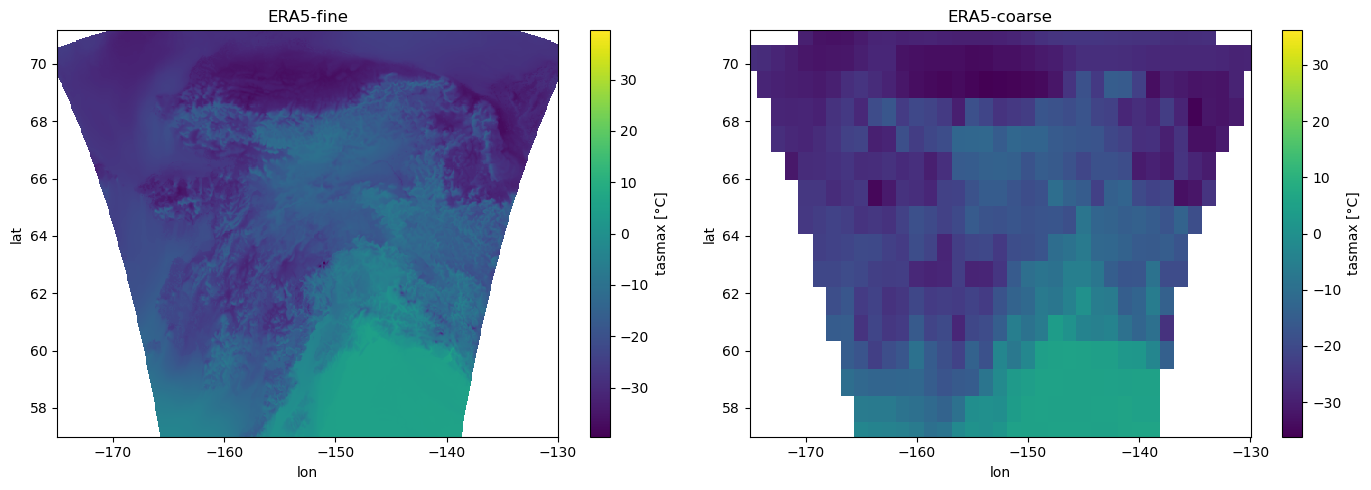

In [5]:
# Select a time slice
time_index = 0  # Change this index to select a different time slice

# Plot the time slice from hist_da
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

fine_ref_da.isel(time=0).plot(ax=axes[0], cmap="viridis")
axes[0].set_title("ERA5-fine")

coarse_ref_da.isel(time=0).plot(ax=axes[1], cmap="viridis")
axes[1].set_title("ERA5-coarse")

plt.tight_layout()
plt.show()

Due to errors in the training step with the full extent, we will try with a bounding box that excludes all nodata from the edges, and is considerably smaller than the full domain to help with memory issues. 

Here is that extent, from ERA5-coarse:

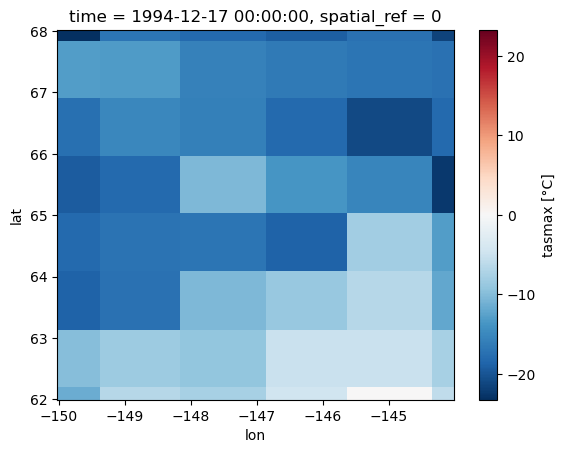

In [6]:
nonan_sel_di = dict(lon=slice(-150, -144), lat=slice(62, 68))
coarse_ref_da.isel(time=0).sel(nonan_sel_di).plot()

Perform the spatial subsets:

In [7]:
coarse_ref_da = coarse_ref_da.sel(nonan_sel_di)
fine_ref_da = fine_ref_da.sel(nonan_sel_di)

Now train the downscaling object. Again, this is based off the above `core` module of the `dodola` repo / package linked above:

In [8]:
# QPLAD method requires that the number of quantiles equals
# the number of days in each day group
# e.g. 20 years of data and a window of 31 = 620 quantiles
window_n = 31
kind = "+"
grouper = sdba.Grouper("time.dayofyear", window=int(window_n))

assert len(coarse_ref_da.time) == len(fine_ref_da.time)
quantiles_n = 620

# check number of years in input data (subtract 2 for the +/- 15 days on each end)
num_years = len(np.unique(fine_ref_da.time.dt.year)) - 2

assert (num_years * int(window_n)) == quantiles_n

qplad = sdba.adjustment.QuantilePreservingAnalogDownscaling.train(
    ref=coarse_ref_da,
    hist=fine_ref_da,
    kind=kind,
    group=grouper,
    nquantiles=quantiles_n,
)

In the spirit of trying to "[avoid very large graphs](https://docs.dask.org/en/stable/best-practices.html#avoid-very-large-graphs)", we will compute the trained dataset object before moving on to the adjustment step. Not sure if this helps or not. 

In [9]:
qplad.ds.load()

<xarray.Dataset>
Dimensions:       (lat: 170, lon: 74, dayofyear: 365, quantiles: 620)
Coordinates:
  * lat           (lat) float64 62.01 62.05 62.08 62.12 ... 67.93 67.96 68.0
  * lon           (lon) float64 -150.0 -149.9 -149.8 ... -144.2 -144.1 -144.1
  * dayofyear     (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * quantiles     (quantiles) float64 0.0008065 0.002419 ... 0.9976 0.9992
    spatial_ref   int64 0
Data variables:
    af            (lat, lon, dayofyear, quantiles) float32 3.874 ... -0.04559
    ref_coarse_q  (lat, lon, dayofyear, quantiles) float32 -30.53 ... -1.782
Attributes:
    _xclim_adjustment:  {"py/object": "xclim.sdba.adjustment.QuantilePreservi...
    adj_params:         QuantilePreservingAnalogDownscaling(group=Grouper(add...

Again, load a single year of bias-adjusted historical GCM data to downscale. 

In [10]:
year = 2000
hist_adj_fine_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted_fine_wgs84.nc"
)
hist_adj_fine = xr.open_dataset(hist_adj_fine_fp)
# subset to the same region as training
hist_adj_fine = hist_adj_fine.sel(nonan_sel_di)
hist_adj_fine

<xarray.Dataset>
Dimensions:      (time: 365, lat: 170, lon: 74)
Coordinates:
  * time         (time) object 2000-01-01 12:00:00 ... 2000-12-31 12:00:00
    spatial_ref  int64 ...
    height       float64 ...
  * lat          (lat) float64 62.01 62.05 62.08 62.12 ... 67.93 67.96 68.0
  * lon          (lon) float64 -150.0 -149.9 -149.8 ... -144.2 -144.1 -144.1
Data variables:
    sim_q        (time, lat, lon) float64 ...
    tasmax       (time, lat, lon) float32 ...
Attributes:
    regrid_method:  nearest_s2d

Now we call the `adjust` method:

In [11]:
# .adjust method expects sim_q as a coordinate
hist_qplad = qplad.adjust(hist_adj_fine.set_coords(["sim_q"])["tasmax"])

Here's a look at a single day time slice from the bias-adjusted GCM (left) and downscaled version (right):

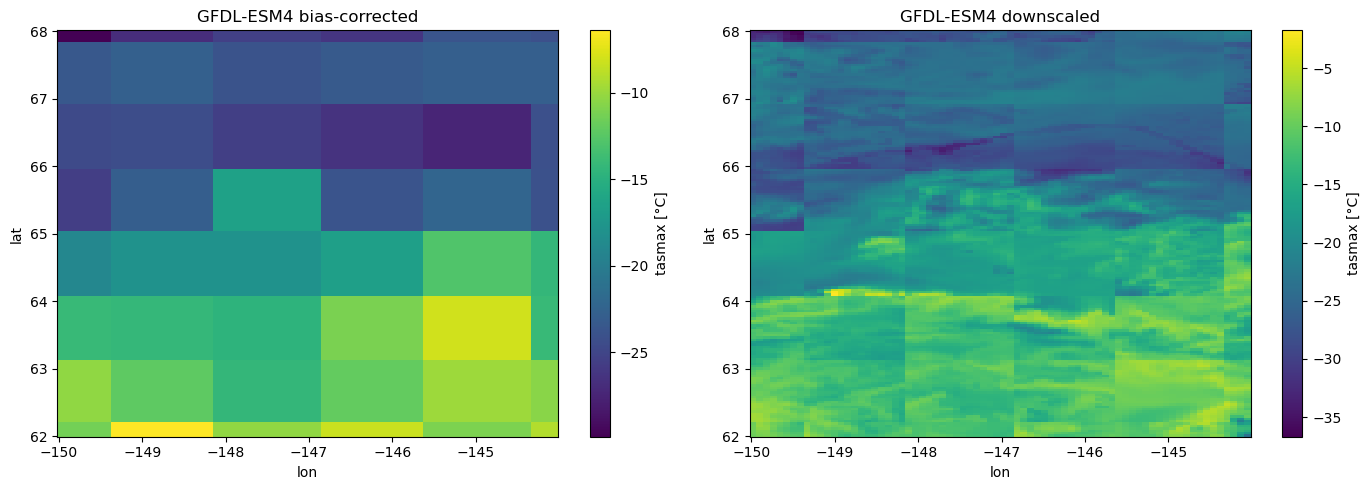

In [12]:
# Select a time slice
time_index = 0

# Plot the time slice from hist_da
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

hist_adj_fine["tasmax"].isel(time=0).plot(ax=axes[0], cmap="viridis")
axes[0].set_title("GFDL-ESM4 bias-corrected")

hist_qplad.rename("tasmax").isel(time=0).transpose("lat", "lon").plot(
    ax=axes[1], cmap="viridis"
)
axes[1].set_title("GFDL-ESM4 downscaled")

plt.tight_layout()
plt.show()

Again, a look at all pixels averaged over the year of data, to see if this helps with the weird artifacts of the resampled CMIP6 common grid that are evident in the above plot:

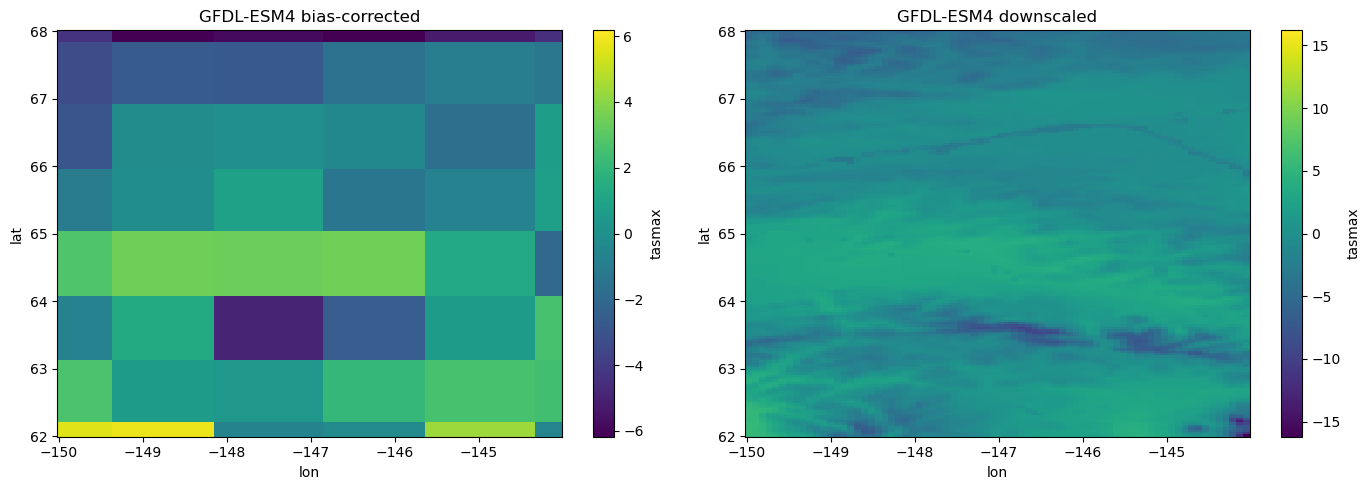

In [14]:
# Plot the time slice from hist_da
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

hist_adj_fine["tasmax"].mean(dim="time").plot(ax=axes[0], cmap="viridis")
axes[0].set_title("GFDL-ESM4 bias-corrected")

hist_qplad.rename("tasmax").transpose("lat", "lon", "time").mean(dim="time").plot(
    ax=axes[1], cmap="viridis"
)
axes[1].set_title("GFDL-ESM4 downscaled")

plt.tight_layout()
plt.show()

And here is another example of summarizing over the year axis, this time using the maximum consecutive warm days indicator:

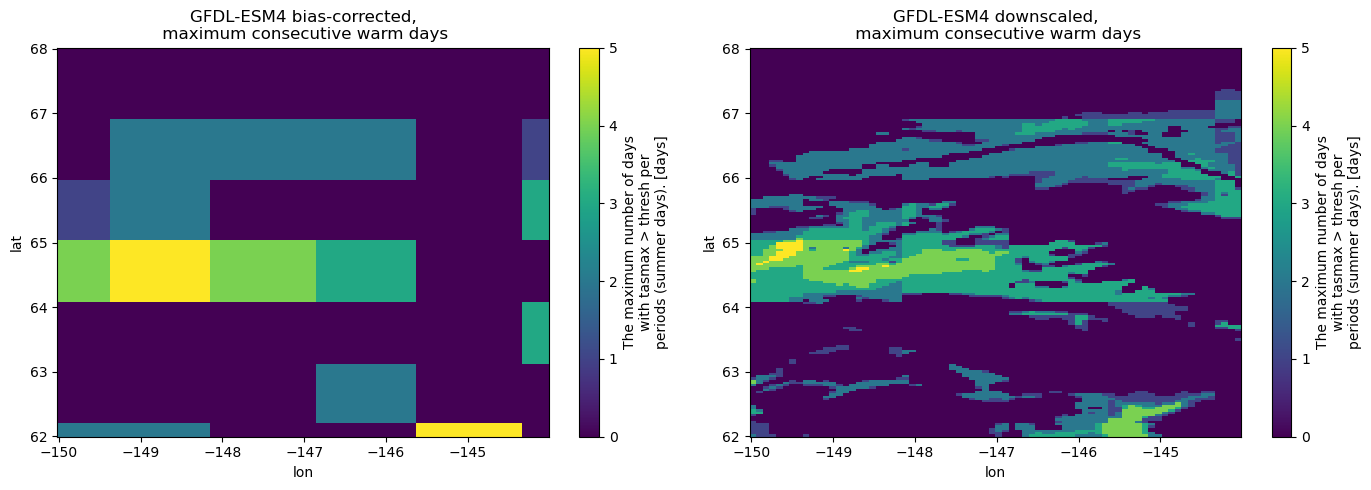

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# doing this to silence warnings about missing CF attributes
with xclim.set_options(
    cf_compliance="log",
):
    xci.atmos.maximum_consecutive_warm_days(hist_adj_fine["tasmax"]).plot(
        ax=axes[0], cmap="viridis"
    )
    xci.atmos.maximum_consecutive_warm_days(hist_qplad.rename("tasmax")).transpose(
        "lat", "lon", "time"
    ).plot(ax=axes[1], cmap="viridis")

axes[0].set_title("GFDL-ESM4 bias-corrected,\n maximum consecutive warm days")
axes[1].set_title("GFDL-ESM4 downscaled,\n maximum consecutive warm days")

plt.tight_layout()
plt.show()

### downscaling unadjusted GCM data

Just an example of downsclaing the unadjusted (biased) GCM data:

In [ ]:
year = 2000
hist_adj_fine_fp = downscaling_dir.joinpath(
    f"GFDL-ESM4_historical_tasmax_{year}_adjusted_fine.nc"
)
hist_adj_fine = xr.open_dataset(hist_adj_fine_fp)
# subset to the same region as training
hist_adj_fine = hist_adj_fine.sel(fine_nonan_sel_di)
hist_adj_fine